In [11]:
from datetime import date, timedelta
import pandas as pd
from cmdty_storage import CmdtyStorage, InjectWithdrawByInventoryAndPeriod, InjectWithdrawByInventory, \
    intrinsic_value


In [12]:
def create_piecewise_flat_series(data, dt_index, freq):
    period_index = pd.PeriodIndex([pd.Period(dt, freq=freq) for dt in dt_index])
    return pd.Series(data, period_index).resample(freq).fillna('pad')

In [13]:
constraints =   [
                    InjectWithdrawByInventoryAndPeriod(date(2019, 8, 28), 
                                [
                                    InjectWithdrawByInventory(0.0, -150.0, 255.2),
                                    InjectWithdrawByInventory(2000.0, -200.0, 175.0),
                                ]),
                    (date(2019, 9, 10), 
                             [
                                 (0.0, -170.5, 235.8),
                                 (700.0, -180.2, 200.77),
                                 (1800.0, -190.5, 174.45),
                            ])
                ]

storage_start = date(2019, 8, 28)
storage_end = date(2019, 9, 25)
constant_injection_cost = 0.015
constant_pcnt_consumed_inject = 0.0001
constant_withdrawal_cost = 0.02
constant_pcnt_consumed_withdraw = 0.000088
constant_pcnt_inventory_loss = 0.001;
constant_pcnt_inventory_cost = 0.002;

cmdty_storage = CmdtyStorage('D', storage_start, storage_end, constant_injection_cost, constant_withdrawal_cost, constraints, 
                        cmdty_consumed_inject=constant_pcnt_consumed_inject, cmdty_consumed_withdraw=constant_pcnt_consumed_withdraw,
                        inventory_loss=constant_pcnt_inventory_loss, inventory_cost=constant_pcnt_inventory_cost)

inventory = 650.0
val_date = date(2019, 9, 2)

forward_curve = create_piecewise_flat_series([58.89, 61.41, 59.89, 59.89], 
                          [val_date, date(2019, 9, 12), date(2019, 9, 18), storage_end], freq='D')

flat_interest_rate = 0.03
interest_rate_curve = pd.Series(index = pd.period_range(val_date, storage_end + timedelta(days=50), freq='D'))
interest_rate_curve[:] = flat_interest_rate

twentieth_of_next_month = lambda period: period.asfreq('M').asfreq('D', 'end') + 20
intrinsic_results = intrinsic_value(cmdty_storage, val_date, inventory, forward_curve, 
                settlement_rule=twentieth_of_next_month, interest_rates=interest_rate_curve, 
                                    num_inventory_grid_points=100)

In [14]:
print("Storage Intrinsic NPV")
print("{:,.2f}".format(intrinsic_results.npv) )

Storage Intrinsic NPV
40,419.45


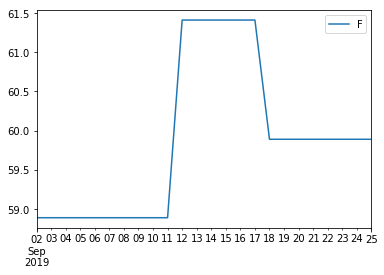

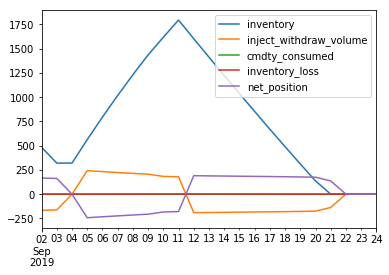

In [15]:
%matplotlib inline
ax = forward_curve.plot(legend=True)
ax.legend("Forward Curve")
intrinsic_results.profile.plot()

In [16]:
intrinsic_results.profile

,inventory,inject_withdraw_volume,cmdty_consumed,inventory_loss,net_position
2019-09-02,483.100000,-166.250000,0.014630,0.650000,166.235370
2019-09-03,320.539400,-162.077500,0.014263,0.483100,162.063237
2019-09-04,320.218861,0.000000,0.000000,0.320539,-0.000000
2019-09-05,562.257865,242.359224,0.024236,0.320219,-242.383460
2019-09-06,794.349067,232.653460,0.023265,0.562258,-232.676725
2019-09-07,1016.901320,223.346602,0.022335,0.794349,-223.368937
2019-09-08,1230.306676,214.422257,0.021442,1.016901,-214.443699
2019-09-09,1434.941072,205.864702,0.020586,1.230307,-205.885289
2019-09-10,1616.690995,183.184865,0.018318,1.434941,-183.203183
2019-09-11,1793.910389,178.836085,0.017884,1.616691,-178.853968


#### Trinomial Tree Valuation Example

In [17]:
from cmdty_storage import trinomial_value

# Trinomial Tree parameters
mean_reversion = 14.5
spot_volatility = create_piecewise_flat_series([1.35, 1.13, 1.24, 1.24],
                           [val_date, date(2019, 9, 12), date(2019, 9, 18), storage_end], freq='D')
time_step = 1.0/365.0

trinomial_value = trinomial_value(cmdty_storage, val_date, inventory, forward_curve,
                spot_volatility, mean_reversion, time_step,
                 settlement_rule=twentieth_of_next_month,
                interest_rates=interest_rate_curve, num_inventory_grid_points=100)

print("Storage Trinomial Tree Model NPV")
print("{:,.2f}".format(trinomial_value) )

Storage Trinomial Tree NPV
42,844.28
